In [1]:
# Lib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

## Data


In [88]:
path = "../data/"
df = pd.read_csv(path + "PJME_hourly.csv")
df.head(), df.tail()

(              Datetime  PJME_MW
 0  2002-12-31 01:00:00  26498.0
 1  2002-12-31 02:00:00  25147.0
 2  2002-12-31 03:00:00  24574.0
 3  2002-12-31 04:00:00  24393.0
 4  2002-12-31 05:00:00  24860.0,
                    Datetime  PJME_MW
 145361  2018-01-01 20:00:00  44284.0
 145362  2018-01-01 21:00:00  43751.0
 145363  2018-01-01 22:00:00  42402.0
 145364  2018-01-01 23:00:00  40164.0
 145365  2018-01-02 00:00:00  38608.0)

It appears that our data starts from 31st Dec 2002 and ends on 2nd Jan 2018, for estimated hourly energy consuimption in MW, of PJM East region. It is fairly common to set the datetime as index for time series data.

 

In [89]:
df.columns
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)            # Convert to datetime

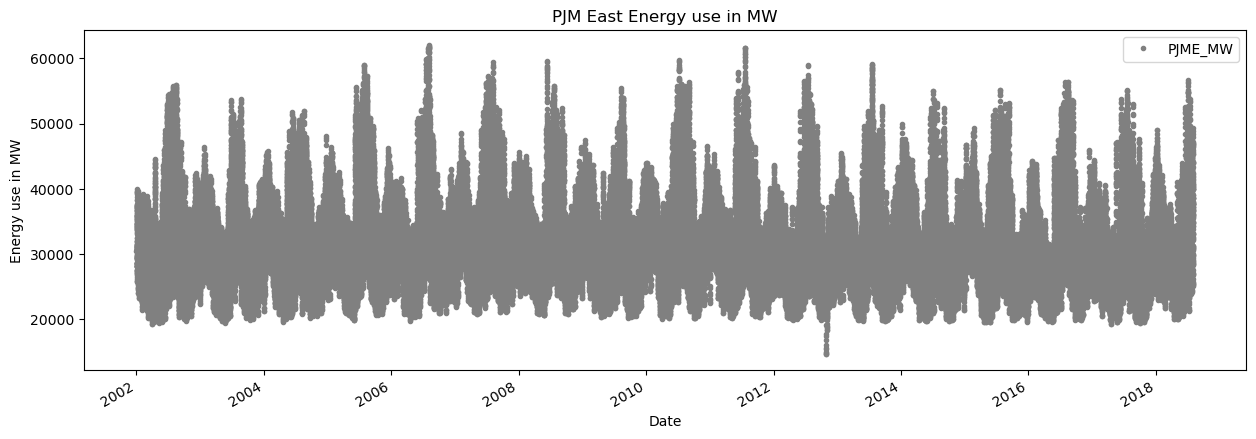

In [90]:
# visualize the data
df.plot(style='.', figsize=(15,5), 
        color = 'grey', 
        title='PJM East Energy use in MW')
plt.ylabel('Energy use in MW')
plt.xlabel('Date')
plt.show()

It appears, the data is pretty decent, where a huge outliers exist in 2013. This might be due to sensor erroe, as it doesnt seems to be a true data. The model is going to learn from this outliers and this needs to be fixed.

## Outliers Analysis and removal


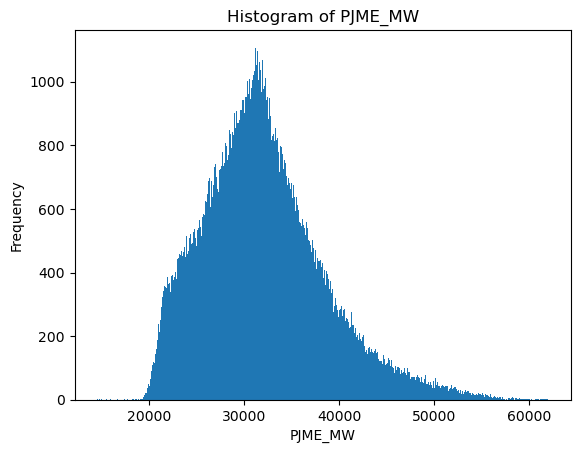

In [93]:
plt.hist(df["PJME_MW"], bins=500)
plt.xlabel("PJME_MW")
plt.ylabel("Frequency")
plt.title("Histogram of PJME_MW")
plt.show()

Looking at the histogram, it appears that most of the data is in the range of 20000 to 50000 (peakup), however, there is some data which is way beyond peakup. This could be due to some outliers or some special events.

<Axes: xlabel='Datetime'>

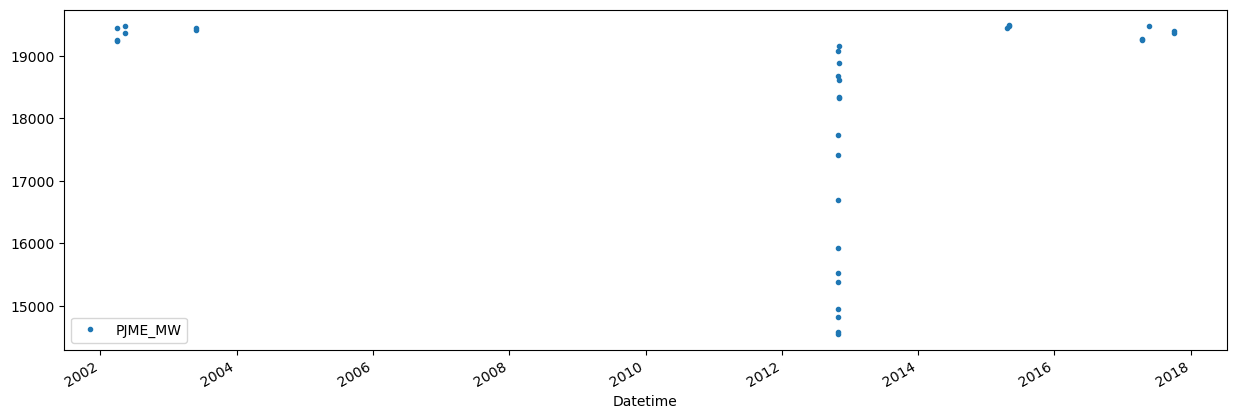

In [99]:
# checking outliers in the data
df.query("PJME_MW<19500").plot(figsize=(15,5), style='.')

To improve the threshold, we see the below 19000 observations


<Axes: xlabel='Datetime'>

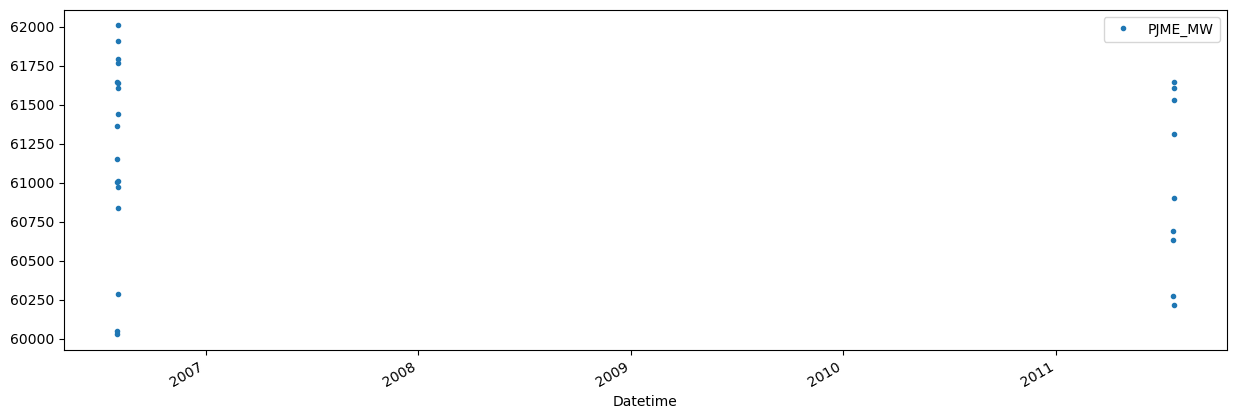

In [98]:
df.query("PJME_MW>60000").plot(figsize=(15,5), style='.')

Removing the values for observations which are <19500 & greater than 60000

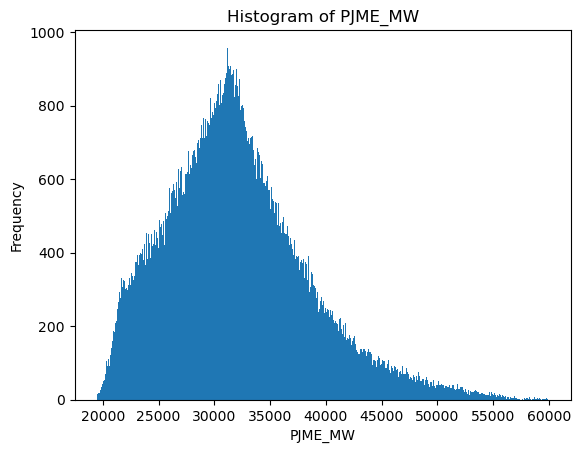

In [101]:
df_new = df[(df["PJME_MW"] >= 19500) & (df["PJME_MW"] <= 60000)]

plt.hist(df_new["PJME_MW"], bins=500)
plt.xlabel("PJME_MW")
plt.ylabel("Frequency")
plt.title("Histogram of PJME_MW")
plt.show()

## Time Series Cross Validation

Setting a TimeseriesSplit and try a future prediction of one year with this hourly data.

In [102]:
from sklearn.model_selection import TimeSeriesSplit

# setting a time series split
tss = TimeSeriesSplit(n_splits=5, test_size= 24*365*1, gap = 24)  # gap = 24 means 24 hours gap between train and test
dataframe = df_new.sort_index()

In [104]:
# looping with tss generator over training dataset, splits the data into 5 folds and returns the indices of the training and validation sets for each fold.
for train_idx, val_idx in tss.split(dataframe):
    break

# This gives us the indices of our training and validation sets. 
train_idx, val_idx

(array([     0,      1,      2, ..., 101481, 101482, 101483]),
 array([101508, 101509, 101510, ..., 110265, 110266, 110267]))

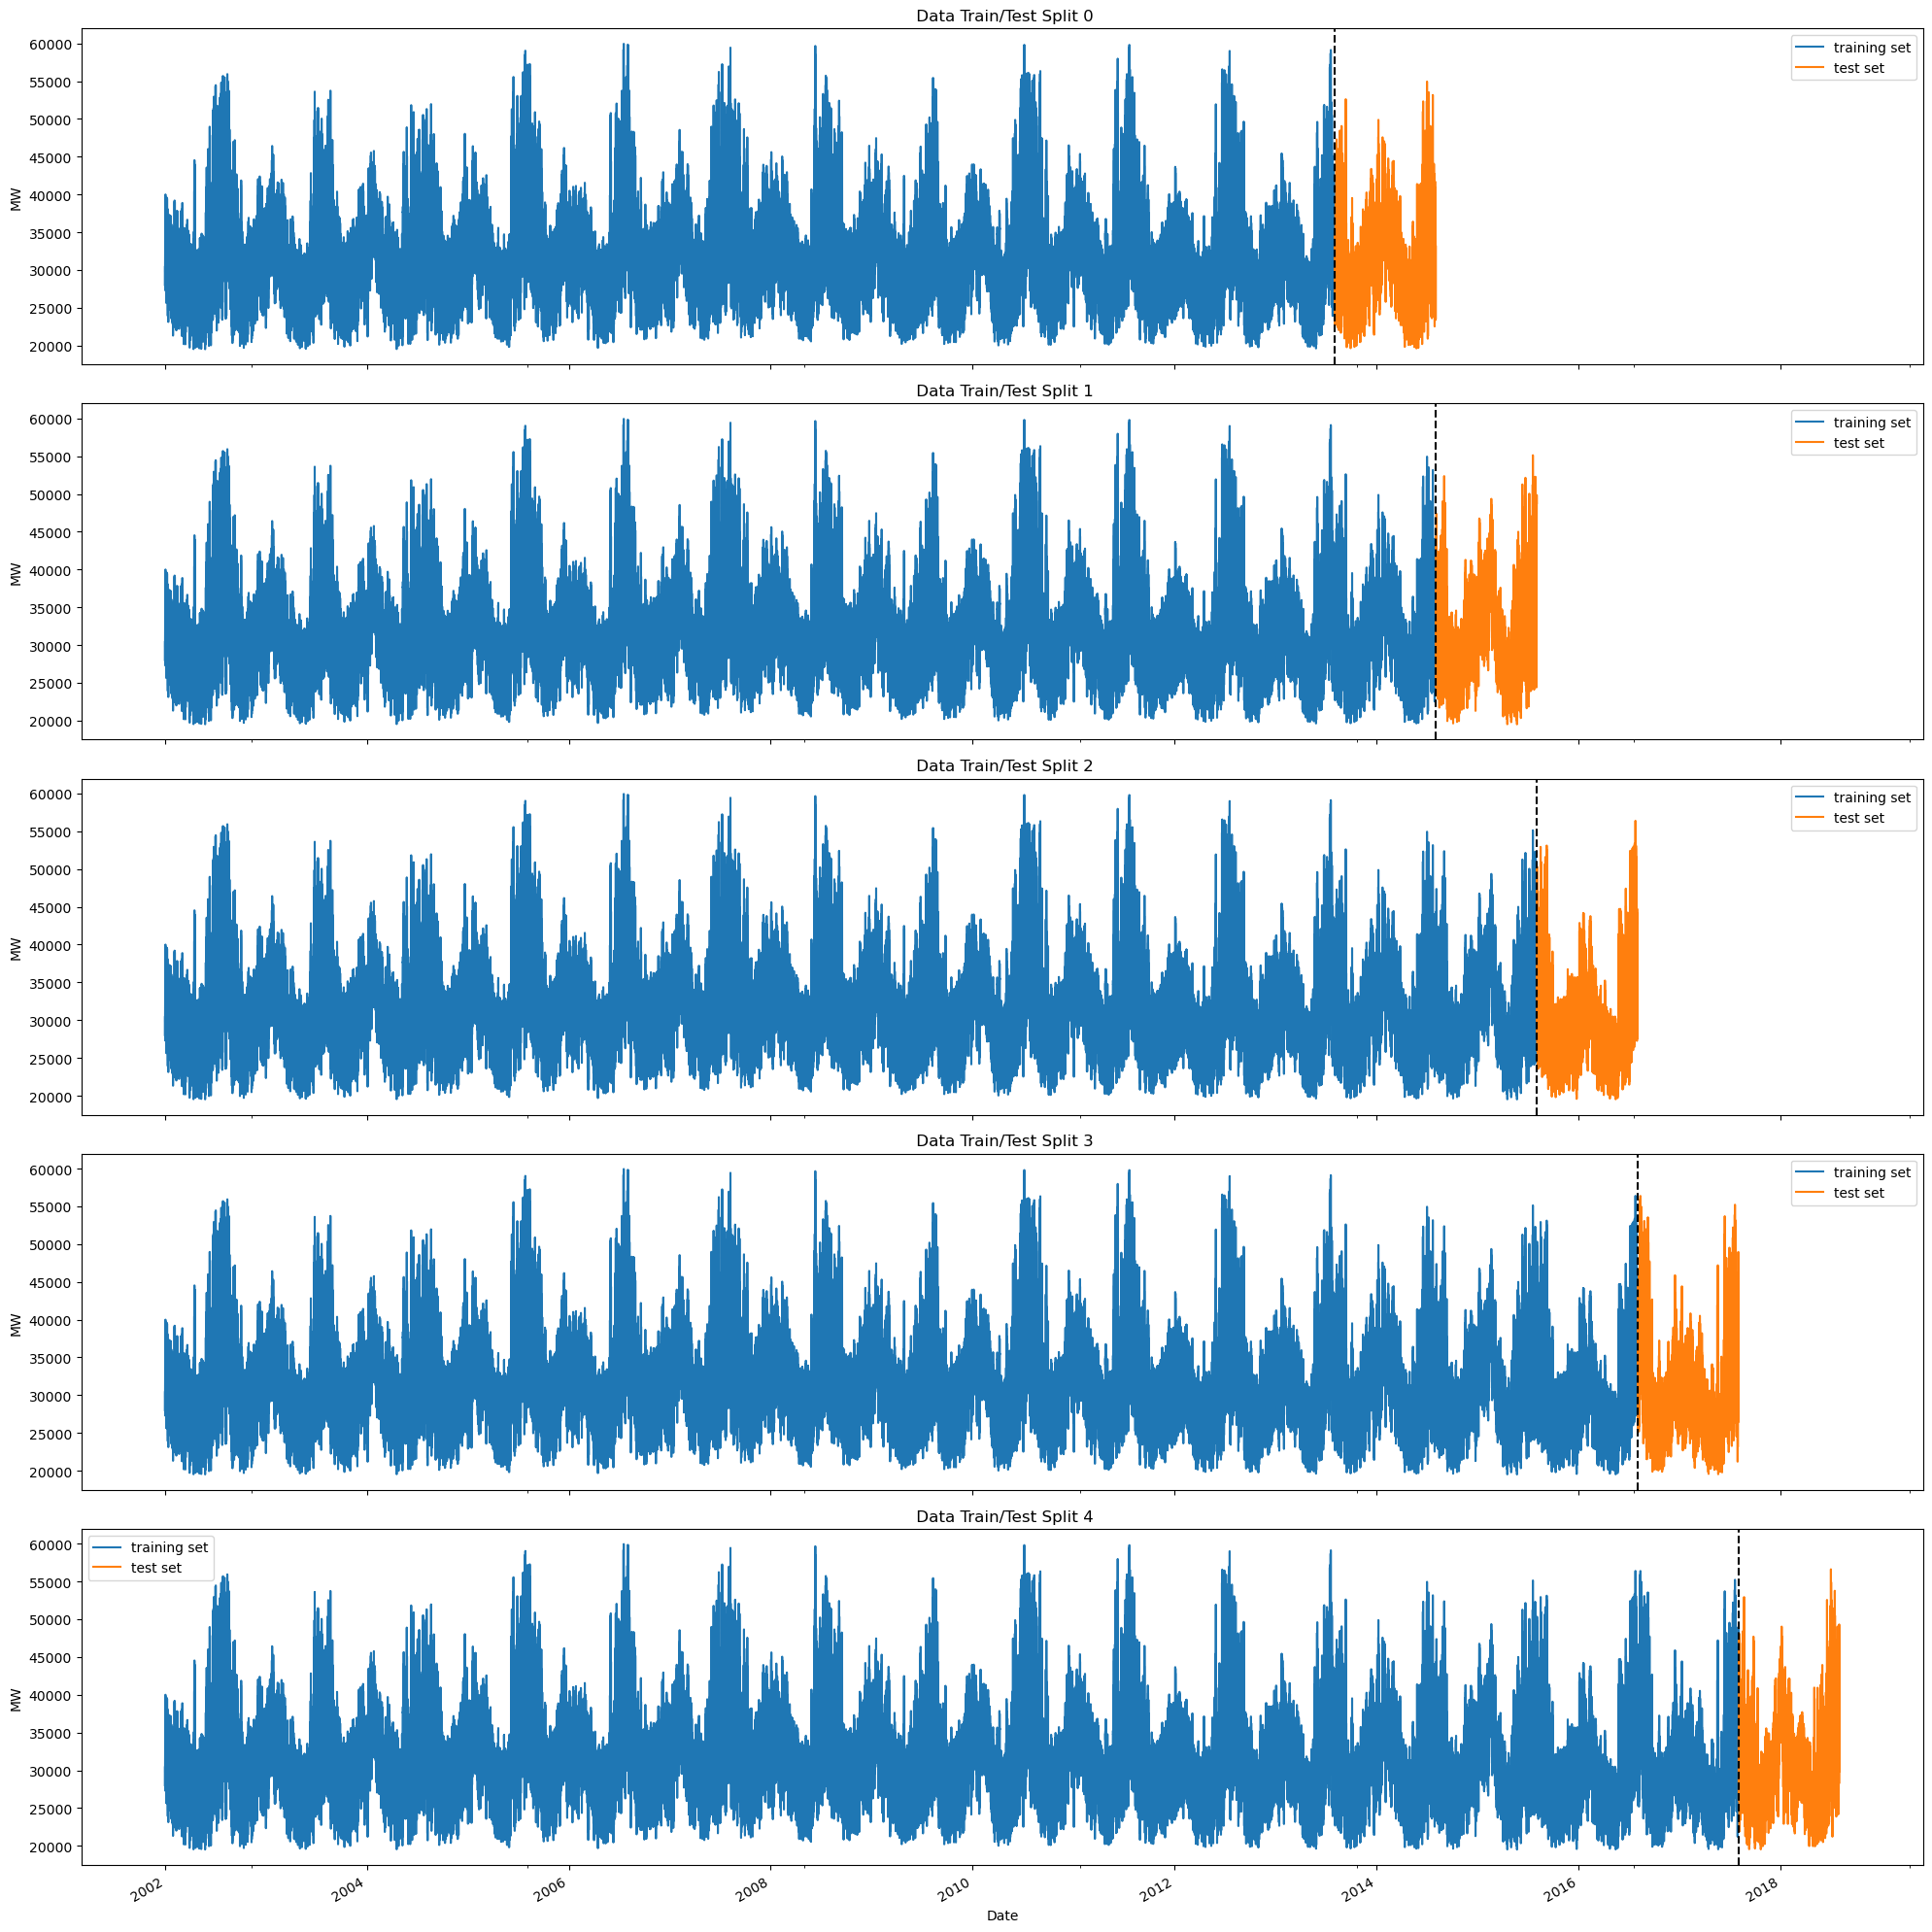

In [107]:
# Plot the training sets agains test (validation) set
fig, ax = plt.subplots(5,1, figsize=(20, 20), sharex=True)  # sharex=True to share the same x axis

fold = 0
for train_idx, val_idx in tss.split(dataframe):
    train = dataframe.iloc[train_idx]
    test = dataframe.iloc[val_idx]

    train["PJME_MW"].plot(ax=ax[fold], label="training set", 
                          title=f" Data Train/Test Split {fold}")
    test["PJME_MW"].plot(ax=ax[fold], label="test set")
    ax[fold].legend()
    ax[fold].set_xlabel("Date")
    ax[fold].set_ylabel("MW")
    ax[fold].axvline(test.index[0], c="black", ls="--")
    fold += 1

plt.tight_layout()
plt.show()


For each fold, we have a year of validation data. It appears we are testing last 5 years independently from eachother. 

## Forcasting horizon

The forecast is the length of time into the future for which forecast are to be prepared. This generally vary from short term forecast (less than 3 months) to long term forecast (3 months or more). In this project, we will be using a short term forecast. <br>

Typically further into the future we forecast, the less accurate the forecast will be. This is because of the uncertainty of the future. An hour or two hour prediction is much easier and accurate than a year or two.<br>

In [108]:
# adding features

def create_feature(df):
    """
    Create features from datetime index
    """
    df["hour"] = df.index.hour
    df["dayofweek"] = df.index.dayofweek
    df["month"] = df.index.month
    df["dayofmonth"] = df.index.day
    df["year"] = df.index.year
    df["dayofyear"] = df.index.dayofyear
    df["weekofyear"] = df.index.weekofyear
    df["quarter"] = df.index.quarter
    return df
    
df = create_feature(dataframe)

C:\Users\Naveed Ul Mustafa\AppData\Local\Temp\ipykernel_16128\407281279.py:13: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df["weekofyear"] = df.index.weekofyear


## Lag Feature
What was the target in the past (x) days? This means, we expect a model to take target values from the past and considers it as a new feature. This is called lag feature. 


In [109]:
target_value = df["PJME_MW"]

# create a dict to map lag features onto dataframe
target_map = target_value.to_dict()


In [110]:
# Lags (364 days a year instead of 365 b/c of perfect divisibility)

def add_lags(df):
    target_map = target_value.to_dict()
    df["lag1"] = (df.index - pd.Timedelta("364 days")).map(target_map)
    df["lag2"] = (df.index - pd.Timedelta("728 days")).map(target_map)
    df["lag3"] = (df.index - pd.Timedelta("1092 days")).map(target_map)
    return df

In [112]:
df = add_lags(df)
df.head()

,PJME_MW,hour,dayofweek,month,dayofmonth,year,dayofyear,weekofyear,quarter,lag1,lag2,lag3
Datetime,,,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,NaN,NaN,NaN


The lag features are empty, b/c we dont create lag values upto this far in the past.

## Train Using Cross Validation

In [113]:
tss = TimeSeriesSplit(n_splits=5, test_size= 24*365*1, gap = 24)  # gap = 24 means 24 hours gap between train and test
df_new = df.sort_index()

fold = 0
preds = []
scores = []
for train_index, test_index in tss.split(df_new):
    print(fold)
    train = df_new.iloc[train_index]
    test = df_new.iloc[test_index]
    
    ts_features = ['hour', 'dayofweek', 'month', 'dayofmonth', 'year',
       'dayofyear', 'weekofyear', 'quarter', 'lag1', 'lag2', 'lag3']
    target = 'PJME_MW'

    X_train = train[ts_features]
    y_train = train[target]

    X_test = test[ts_features]
    y_test = test[target]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', 
                           n_estimators=1000, learning_rate=0.1,
                           max_depth=3, early_stopping_rounds=50,
                           objective='reg:squarederror')
    
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose= 100)
    
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

    fold += 1

    

0
[0]	validation_0-rmse:29799.16297	validation_1-rmse:29065.99049
[89]	validation_0-rmse:3144.73959	validation_1-rmse:3812.72918
1
[0]	validation_0-rmse:29745.38867	validation_1-rmse:29247.61019
[100]	validation_0-rmse:3139.98350	validation_1-rmse:3430.95001
[200]	validation_0-rmse:2945.02442	validation_1-rmse:3390.36397
[255]	validation_0-rmse:2880.35230	validation_1-rmse:3393.10817
2
[0]	validation_0-rmse:29708.35892	validation_1-rmse:28175.82126
[84]	validation_0-rmse:3226.54005	validation_1-rmse:3678.27547
3
[0]	validation_0-rmse:29615.61732	validation_1-rmse:28644.99186
[100]	validation_0-rmse:3184.85898	validation_1-rmse:4044.47265
[200]	validation_0-rmse:2996.29506	validation_1-rmse:3968.80249
[300]	validation_0-rmse:2889.63231	validation_1-rmse:3903.04031
[378]	validation_0-rmse:2820.18783	validation_1-rmse:3904.83783
4
[0]	validation_0-rmse:29556.50496	validation_1-rmse:28607.11003
[88]	validation_0-rmse:3267.09302	validation_1-rmse:4038.82562


In [114]:
scores

[3754.2941321055446,
 3386.552477551193,
 3507.6361807511284,
 3889.1300650128596,
 3997.118033196606]

In [116]:
# cross val scores which can be improved

print(f"Scores acreoss folds: {np.mean(scores):0.2f}")
print(f"Fold scores: {scores}")

Scores acreoss folds: 3706.95
Fold scores: [3754.2941321055446, 3386.552477551193, 3507.6361807511284, 3889.1300650128596, 3997.118033196606]


## Predict in the future
- Retrain on all data        
- Need an empty dataframe for future data ranges (skeleton frame of desirable dates)
- Run those through feature creation and lag creation

In [119]:
# Retrain on all data
ts_features = ['hour', 'dayofweek', 'month', 'dayofmonth', 'year',
       'dayofyear', 'weekofyear', 'quarter', 'lag1', 'lag2', 'lag3']
target = 'PJME_MW'

X_all = df_new[ts_features]
y_all = df_new[target]

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', 
       n_estimators=1000, learning_rate=0.1,
       max_depth=3, early_stopping_rounds=50,
       objective='reg:squarederror')
    
reg.fit(X_all, y_all,
       eval_set=[(X_all, y_all)],
       verbose= 100)

[0]	validation_0-rmse:29504.48561


[100]	validation_0-rmse:3274.79440
[200]	validation_0-rmse:3092.51446
[300]	validation_0-rmse:2983.96030
[400]	validation_0-rmse:2906.70574
[500]	validation_0-rmse:2844.02858
[600]	validation_0-rmse:2790.83906
[700]	validation_0-rmse:2741.68481
[800]	validation_0-rmse:2697.46539
[900]	validation_0-rmse:2660.79991
[999]	validation_0-rmse:2622.07602


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [128]:
# create future dates dataframe
df_new.index.max()

future = pd.date_range(start=df_new.index.max(), end='2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future, columns=df_new.columns)

future_df.head()

# add a distinguish column b/w the old and future dataframes
future_df['forecast'] = True
df_new['forecast'] = False

# combine the two dataframes
df = pd.concat([df_new, future_df])

df.head()

df = create_feature(df)
df = add_lags(df)



C:\Users\Naveed Ul Mustafa\AppData\Local\Temp\ipykernel_16128\407281279.py:13: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df["weekofyear"] = df.index.weekofyear


In [129]:
future_wd_features = df.query("forecast").copy()
future_wd_features

,PJME_MW,hour,dayofweek,month,dayofmonth,year,dayofyear,weekofyear,quarter,lag1,lag2,lag3,forecast
2018-08-03 00:00:00,NaN,0,4,8,3,2018,215,31,3,33539.0,32094.0,31695.0,True
2018-08-03 01:00:00,NaN,1,4,8,3,2018,215,31,3,30781.0,29503.0,29128.0,True
2018-08-03 02:00:00,NaN,2,4,8,3,2018,215,31,3,29015.0,27712.0,27373.0,True
2018-08-03 03:00:00,NaN,3,4,8,3,2018,215,31,3,27884.0,26535.0,26233.0,True
2018-08-03 04:00:00,NaN,4,4,8,3,2018,215,31,3,27223.0,25870.0,25643.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,7,31,2019,212,31,3,46912.0,39352.0,40243.0,True
2019-07-31 21:00:00,NaN,21,2,7,31,2019,212,31,3,45985.0,38699.0,39183.0,True
2019-07-31 22:00:00,NaN,22,2,7,31,2019,212,31,3,44094.0,37346.0,37759.0,True
2019-07-31 23:00:00,NaN,23,2,7,31,2019,212,31,3,40666.0,34555.0,34641.0,True


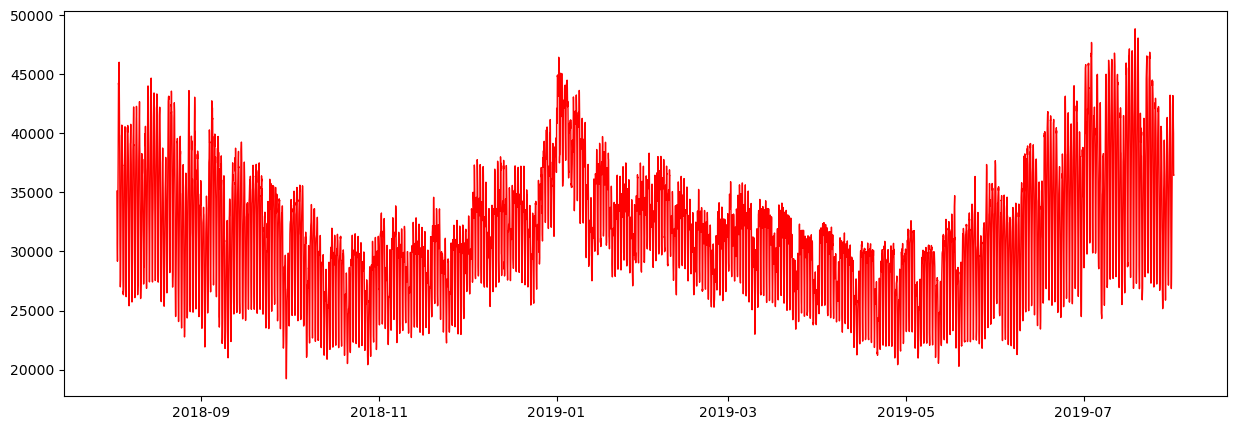

In [133]:
# Future predictions
future_wd_features["prediction"] = reg.predict(future_wd_features[ts_features])

# plot the results
plt.figure(figsize=(15, 5))
plt.plot(future_wd_features.index, future_wd_features["prediction"], 
         color="red", label="prediction",
         ms = 1, lw = 1)
plt.show()

## Train/Test split
Spliting the data at Jan 2015. Data before Jan 2015 is used for training and data after Jan 2015 is used for testing.

In [32]:
train = df.loc[df.index < "01-01-2015"]
test = df.loc[df.index >= "01-01-2015"]

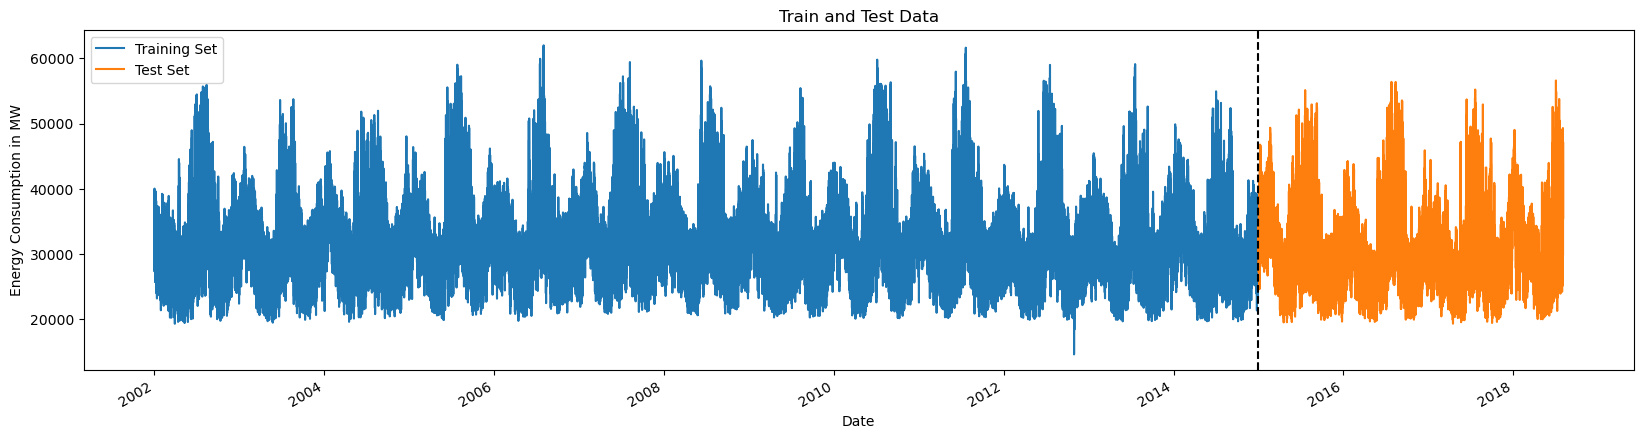

In [34]:
# visualizing the train and test data
fig, ax = plt.subplots( figsize=(20, 5))        # in a same figure
train.plot(ax=ax, label = "Training set")                               # plot train data
test.plot(ax=ax, label = "Test set")                                # plot test data    
ax.set_xlabel("Date")                                                   # set x label
ax.set_ylabel("Energy Consumption in MW")                                                  # set y label
ax.set_title("Train and Test Data")                                      # set title
ax.axvline(test.index[0], color='black', linestyle='--')     # draw a vertical line at the start of test data
ax.legend(["Training Set", "Test Set"])                                              # set legend
plt.show()

#### What's one single week of the data looks like?

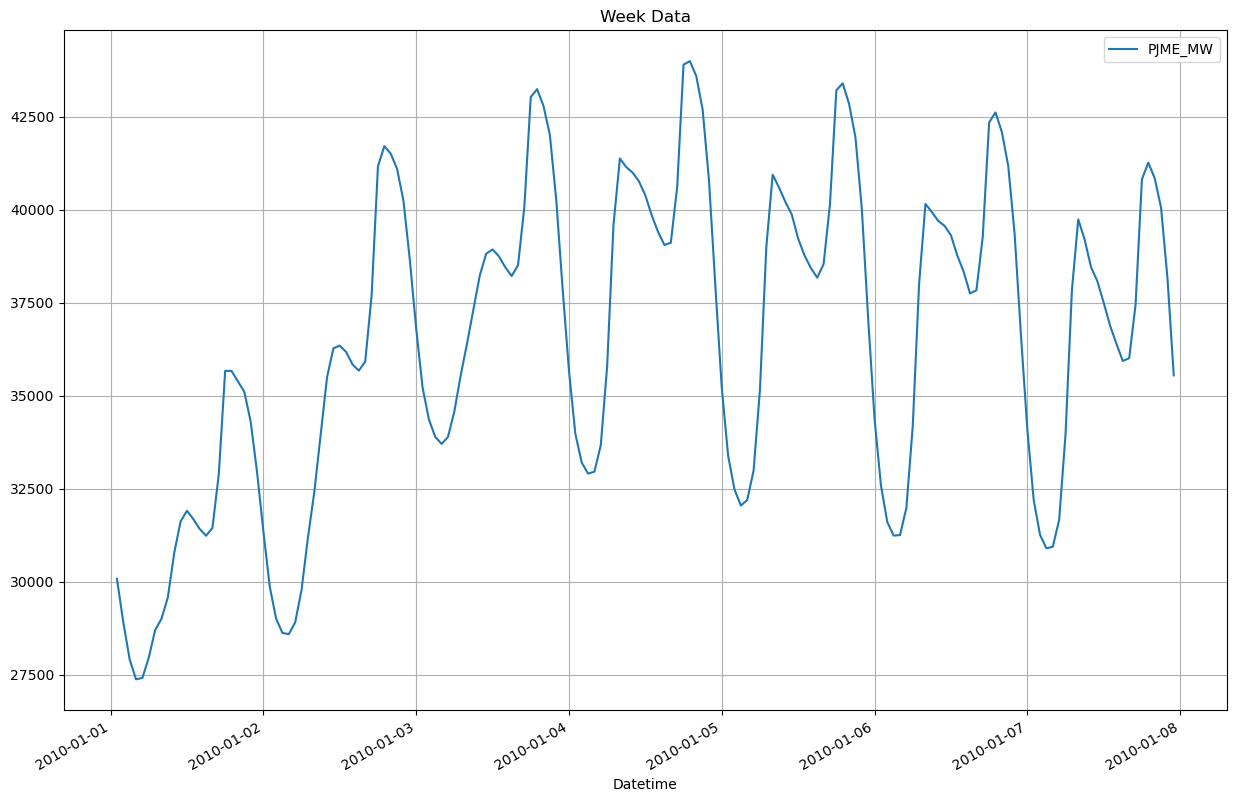

In [37]:
df.loc[(df.index > "01-01-2010") & (df.index < "01-08-2010")].plot(
    figsize=(15, 10), grid=True, title = "Week Data"
)
plt.show()

Everyday there are 2 peaks, pretty common in Energy consumptiion and valleys during the night. The peaks are around 12:00 and 18:00. The valleys are around 6:00 and 0:00. The sililar trend but at lower scale indicates that the first day od the week is a holiday.

## Feature Engineering
Creating features using time series index.

In [38]:
df.index.hour # 0-23

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
            ...
            15, 16, 17, 18, 19, 20, 21, 22, 23,  0],
           dtype='int64', name='Datetime', length=145366)

In [43]:
df = create_feature(df)
df.head()

C:\Users\Naveed Ul Mustafa\AppData\Local\Temp\ipykernel_16128\3129853179.py:11: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df["weekofyear"] = df.index.weekofyear


,PJME_MW,hour,dayofweek,month,dayofmonth,year,dayofyear,weekofyear,quarter
Datetime,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,12,31,2002,365,1,4
2002-12-31 02:00:00,25147.0,2,1,12,31,2002,365,1,4
2002-12-31 03:00:00,24574.0,3,1,12,31,2002,365,1,4
2002-12-31 04:00:00,24393.0,4,1,12,31,2002,365,1,4
2002-12-31 05:00:00,24860.0,5,1,12,31,2002,365,1,4


## Visualiuze Features/ Target relationships

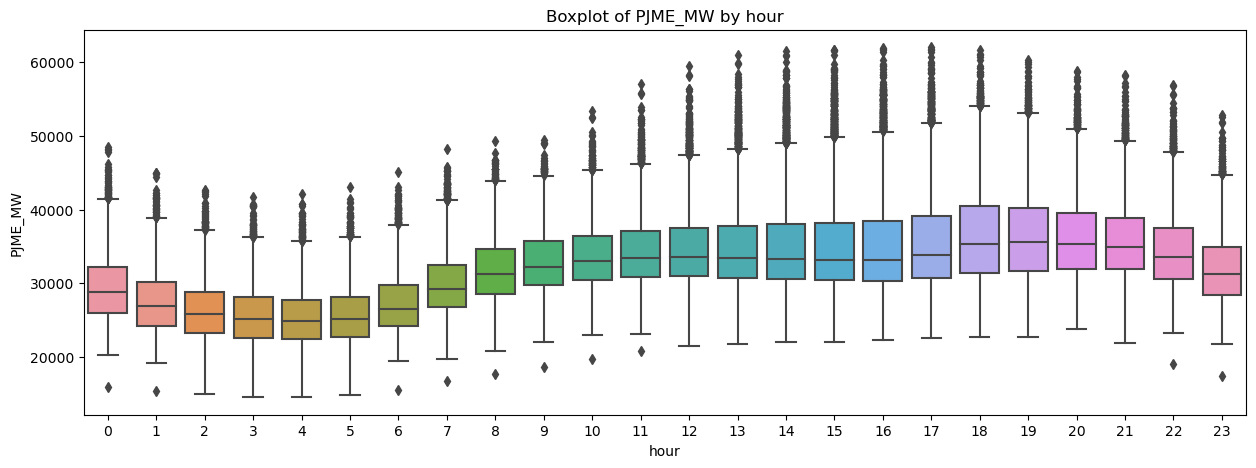

In [44]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(df, x = "hour", y = "PJME_MW")
ax.set_title("Boxplot of PJME_MW by hour")
plt.show()


In early hours of a day, the energy consumption is low. It increases during the day and peaks in the evening. 

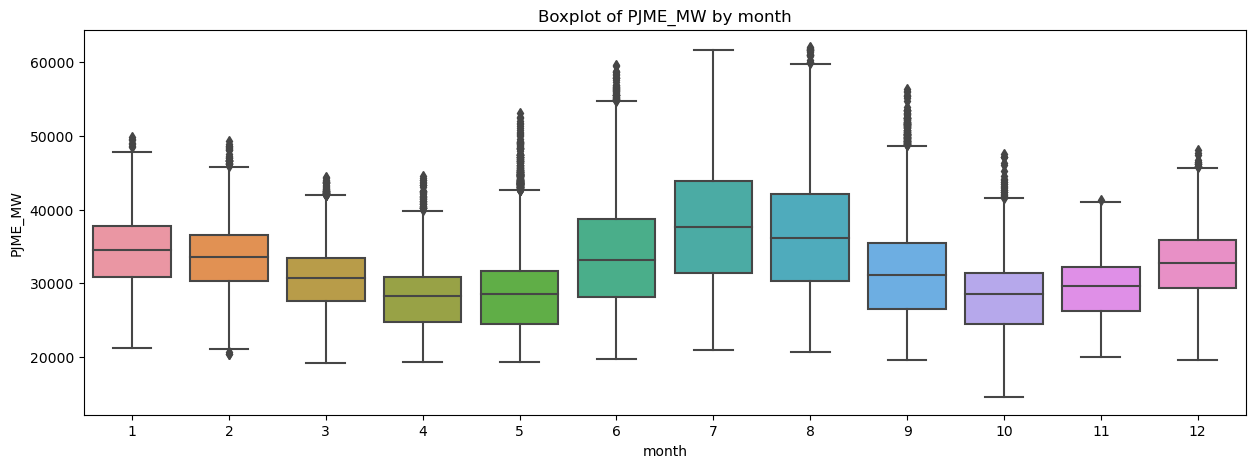

In [45]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(df, x = "month", y = "PJME_MW")
ax.set_title("Boxplot of PJME_MW by month")
plt.show()

The Energy consumption seems to increase from Apr and peaked in July, due to the summer season. The consumption is lowest in Apr, May and oct. This expalins the seasonality in the data, as spring and autumn hit, the consumption is low. The consumption is highest in summer followed by winters.

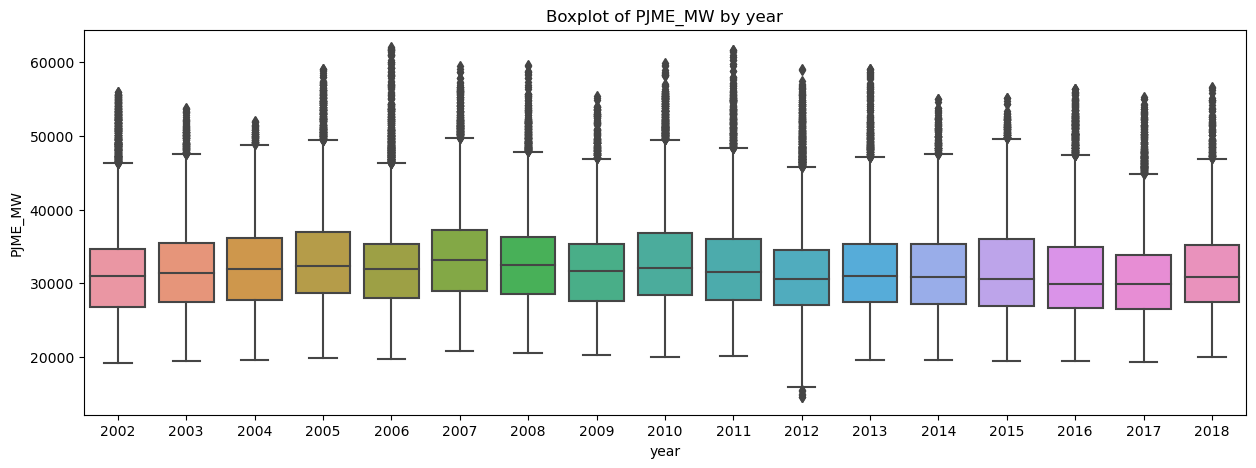

In [46]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(df, x = "year", y = "PJME_MW")
ax.set_title("Boxplot of PJME_MW by year")
plt.show()

Over the years, consumption remains same. However v low outliers in 2012.

## Model Building

In [47]:
from sklearn.metrics import mean_squared_error

# update Train and test dataset
train = create_feature(train)
test = create_feature(test)



C:\Users\Naveed Ul Mustafa\AppData\Local\Temp\ipykernel_16128\3129853179.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hour"] = df.index.hour
C:\Users\Naveed Ul Mustafa\AppData\Local\Temp\ipykernel_16128\3129853179.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["dayofweek"] = df.index.dayofweek
C:\Users\Naveed Ul Mustafa\AppData\Local\Temp\ipykernel_16128\3129853179.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

In [48]:
df.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'month', 'dayofmonth', 'year',
       'dayofyear', 'weekofyear', 'quarter'],
      dtype='object')

In [49]:
ts_features = ['hour', 'dayofweek', 'month', 'dayofmonth', 'year',
       'dayofyear', 'weekofyear', 'quarter']
target = 'PJME_MW'

In [50]:
X_train = train[ts_features]
y_train = train[target]
X_test = test[ts_features]
y_test = test[target]

In [54]:
# XGBoost Regressor
xgb_reg = xgb.XGBRegressor(n_estimators=100, learning_rate=0.01, gamma=0, 
                           subsample=0.75, colsample_bytree=1, max_depth=7,
                           early_stopping_rounds = 50)
# Fit the model
xgb_reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose= 100)   # verbose=True prints the evaluation metric every 100 steps 


[0]	validation_0-rmse:32601.52210	validation_1-rmse:31653.35302


[99]	validation_0-rmse:12425.29906	validation_1-rmse:11705.70713


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Initially, as train data added, rmse for train and test shows a decreasing trend, however, on test set it appeared that rmse started rising, typical case of overfitting. Early stopping has stopped it, now trying lowring the learning rate from 0.08 - 0.01 to make it more robust. <br>

After lowering the learning rate, the rmse started to get worse after 99 trees, so early stopping has stopped it. <br>





## Feature importances

In [56]:
# checking which feature is most important by our model
xgb_reg.feature_importances_

array([0.33418125, 0.17088725, 0.24380456, 0.00793013, 0.01390812,
       0.18349516, 0.04579355, 0.        ], dtype=float32)

In [61]:
# Make a dataframe of the feature importance
model = xgb_reg
fi = pd.DataFrame({'feature': X_train.columns, 'importance': model.feature_importances_})
# Sort features according to importance
fi.sort_values('importance', ascending = False, inplace = True)

# Set index to 'feature'
fi.set_index('feature', inplace = True)
fi.head(10)



,importance
feature,
hour,0.334181
month,0.243805
dayofyear,0.183495
dayofweek,0.170887
weekofyear,0.045794
year,0.013908
dayofmonth,0.007930
quarter,0.000000


<Figure size 1500x500 with 0 Axes>

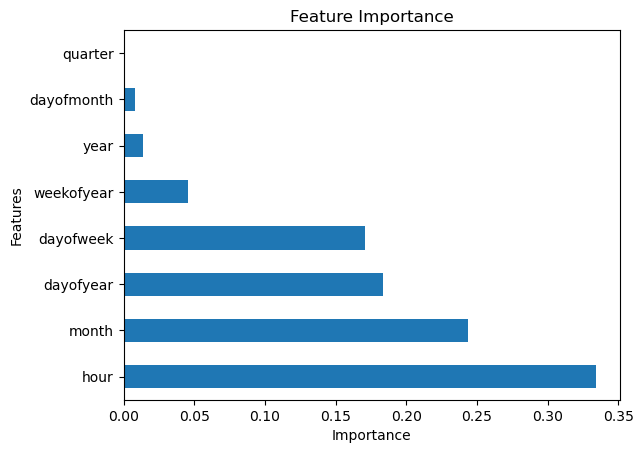

In [62]:
# Plot the feature importance
plt.figure(figsize=(15, 5))
fi.plot(kind='barh', title='Feature Importance', legend=False)
plt.ylabel('Features')
plt.xlabel('Importance')
plt.show()

It appears, our model been using hour feature followed by month, dayofyear and so on. There is some overlapping and if we tend to remove the overlapping features, we can see the model performance is improved. 

## Forcast on the Test Set

In [63]:
# store the model predictions in our test set
test['prediction'] = model.predict(X_test)

C:\Users\Naveed Ul Mustafa\AppData\Local\Temp\ipykernel_16128\3864373789.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = model.predict(X_test)


In [65]:
# Now merge the two dataframes

# add additional column to train
train['prediction'] = np.nan

# merge train and test
df = pd.concat([train, test], axis=0, sort=False)
df.head()
df.tail()

C:\Users\Naveed Ul Mustafa\AppData\Local\Temp\ipykernel_16128\1823986362.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['prediction'] = np.nan


,PJME_MW,hour,dayofweek,month,dayofmonth,year,dayofyear,weekofyear,quarter,prediction
Datetime,,,,,,,,,,
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1,1,1,22582.585938
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1,1,1,22582.585938
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1,1,1,22241.847656
2018-01-01 23:00:00,40164.0,23,0,1,1,2018,1,1,1,21157.265625
2018-01-02 00:00:00,38608.0,0,1,1,2,2018,2,1,1,19925.531250


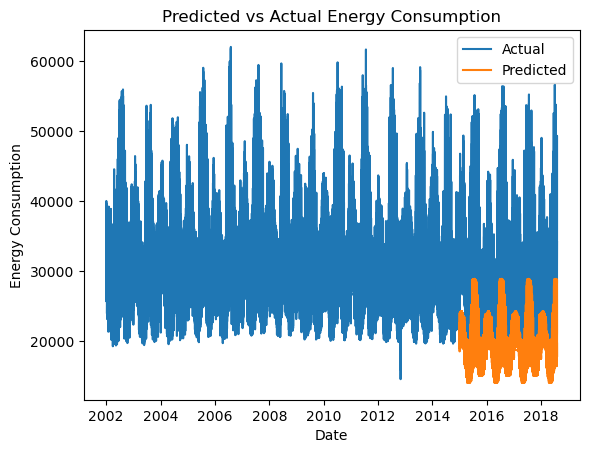

In [74]:
# Plot the new df with predictions
plt.plot(df.index, df["PJME_MW"], label="Actual")
plt.plot(df.index, df["prediction"], label="Predicted")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Energy Consumption")
plt.title("Predicted vs Actual Energy Consumption")
plt.show()


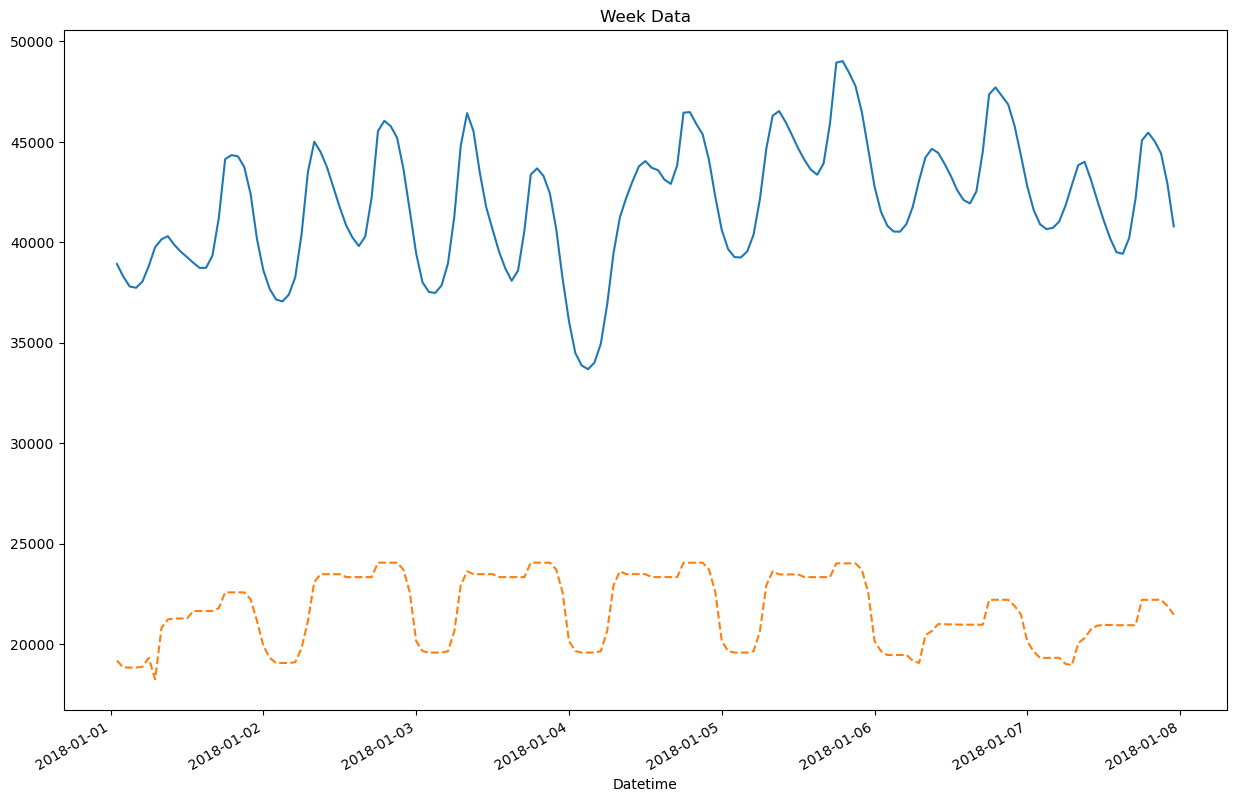

In [79]:
# Visualizing a week

df.loc[(df.index > "01-01-2018") & (df.index < "01-08-2018")]["PJME_MW"].plot(
    figsize=(15, 10), grid=True, title = "Week Data"
)
df.loc[(df.index > "01-01-2018") & (df.index < "01-08-2018")]["prediction"].plot(style = "--")
plt.show()

Model isnt perfect and can be improved by adding more data and training for more epochs. It can loosely fllow the trend of power consumption.

## Calculate Error
observing the worst and best predicted days

In [80]:
test.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'month', 'dayofmonth', 'year',
       'dayofyear', 'weekofyear', 'quarter', 'prediction'],
      dtype='object')

In [83]:
test["error"] = np.abs(test["PJME_MW"] - test["prediction"])

C:\Users\Naveed Ul Mustafa\AppData\Local\Temp\ipykernel_16128\213796786.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["error"] = np.abs(test["PJME_MW"] - test["prediction"])


In [85]:
# worst and best predicted days
test.groupby("dayofyear").mean().sort_values("error").head(5)

,PJME_MW,hour,dayofweek,month,dayofmonth,year,weekofyear,quarter,prediction,error
dayofyear,,,,,,,,,,
290,24981.972222,11.5,4.000000,10.0,16.666667,2016.0,41.666667,4.0,17541.974609,7439.998400
155,27867.250000,11.5,3.250000,6.0,3.750000,2016.5,22.500000,2.0,20322.437500,7544.813009
330,26296.291667,11.5,4.333333,11.0,25.666667,2016.0,47.333333,4.0,18740.117188,7556.176012
298,25646.388889,11.5,2.666667,10.0,24.666667,2016.0,43.000000,4.0,18002.343750,7644.045926
289,25741.500000,11.5,3.000000,10.0,15.666667,2016.0,41.666667,4.0,18044.873047,7696.626153


In [86]:
# worst and best predicted days

test["date"] = test.index.date

# Avg error per day
test.groupby("date")["error"].mean().sort_values(ascending=False).head(10)

C:\Users\Naveed Ul Mustafa\AppData\Local\Temp\ipykernel_16128\3754816299.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["date"] = test.index.date


date
2016-08-13    24589.043620
2016-08-14    23927.115316
2018-01-06    22850.197428
2015-02-20    22622.435710
2016-09-10    22500.590942
2016-09-09    22398.144328
2015-02-16    21901.281657
2016-08-12    21769.033610
2018-01-05    21760.975667
2018-01-07    21532.287598
Name: error, dtype: float64

it appears that the worst predicted days are in mid Aug 2016. 

In [87]:
test.groupby("date")["error"].mean().sort_values(ascending=True).head(10)

date
2017-02-19    3965.312012
2017-02-25    4048.689616
2016-07-04    4119.185465
2017-09-02    4278.269938
2017-02-24    4352.795654
2017-09-09    4461.528931
2015-12-25    4476.056559
2017-05-29    4529.822469
2017-09-03    4600.211751
2017-09-10    4628.111165
Name: error, dtype: float64

Some of the best prediction are made in Feb 2017.